<a href="https://colab.research.google.com/github/gjoni/trDesign/blob/master/02-GD/notebooks/SI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/design/1QYS.pdb
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/design/6MRR.pdb
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/design/utils.py
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/design/models_.py
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/models.zip
unzip -qqo models.zip

In [2]:
import numpy as np
import matplotlib.pylab as plt
from utils import *
from models_ import *

## OPTIMIZER TEST

## TOP7

In [ ]:
pdb = prep_input("1QYS.pdb")
_feat = pdb["feat"][None]
_seq = np.eye(20)[AA_to_N(pdb["seq"])[0]][None,None]

In [ ]:
# setup model for design
# using diag=0.0, since this is what is used in the MCMC run
model = mk_design_model(add_pdb=True, diag=0.0)

mode: single sequence design
loading model: xaa
loading model: xab
loading model: xac
loading model: xad
loading model: xae
The loss function is composed of the following: ['pdb']


In [ ]:
pred = model.predict(inputs={"I":_seq,"pdb":_feat}, weights={}, train=False)

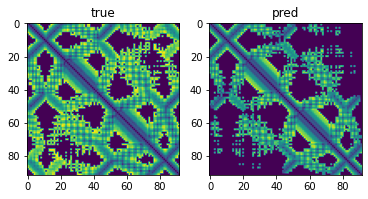

In [ ]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.title("true"); plt.imshow(split_feat(_feat[0])["dist"].argmax(-1))
plt.subplot(1,2,2); plt.title("pred"); plt.imshow(split_feat(pred["feat"][0])["dist"].argmax(-1))

In [ ]:
wt_line = pred["loss"][0,0]
wt_line

1.5157034

In [ ]:
top7_GD = []
for k in range(5):
  top7_GD.append(model.design(inputs={"pdb":_feat}, weights={}, opt_iter=200))

In [ ]:
top7_GD_decay = []
for k in range(5):
  top7_GD_decay.append(model.design(inputs={"pdb":_feat}, weights={},
                                    opt_iter=100, opt_method="GD_decay"))

In [ ]:
model = mk_design_model(add_pdb=True, sample=True, diag=0.0)

mode: single sequence design
loading model: xaa
loading model: xab
loading model: xac
loading model: xad
loading model: xae
The loss function is composed of the following: ['pdb']


In [ ]:
top7_GD_sample = []
for k in range(5):
  top7_GD_sample.append(model.design(inputs={"pdb":_feat}, weights={}, opt_iter=200))

In [ ]:
top7_GD_decay_sample = []
for k in range(5):
  top7_GD_decay_sample.append(model.design(inputs={"pdb":_feat}, weights={},
                                           opt_iter=100, opt_method="GD_decay"))

In [ ]:
# precomputed MCMC trajectories
%%bash
wget -qnc https://files.ipd.uw.edu/krypton/paper2/log_mcmc/mcmc.log
wget -qnc https://files.ipd.uw.edu/krypton/paper2/log_mcmc/seq.txt

In [ ]:
log_mcmc = np.loadtxt("mcmc.log")[:,2].reshape(20,-1)/4
seq_mcmc = np.eye(20)[AA_to_N(np.loadtxt("seq.txt",np.str))]
mcmc_line = log_mcmc[:,-1].mean()
mcmc_line

1.2199211239814758

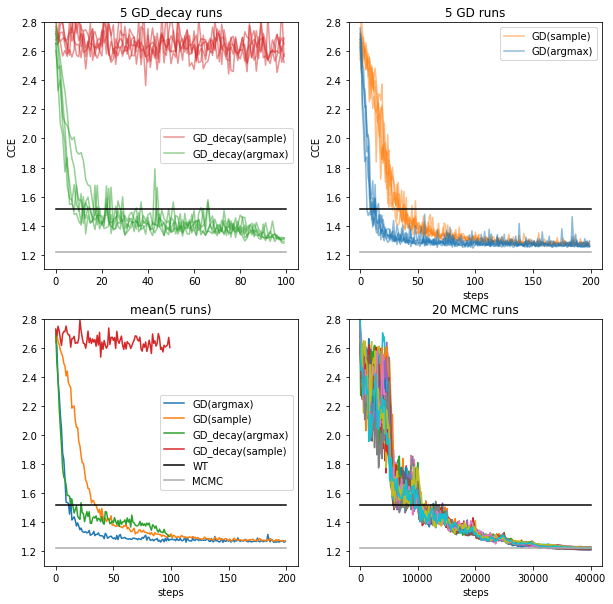

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title("5 GD_decay runs")
for k in range(5):
  label = "GD_decay(sample)" if k == 0 else None
  plt.plot(top7_GD_decay_sample[k]["losses"], label=label,c="tab:red",alpha=0.5)
for k in range(5):
  label = "GD_decay(argmax)" if k == 0 else None
  plt.plot(top7_GD_decay[k]["losses"], label=label,c="tab:green",alpha=0.5)

plt.plot([0,100],[wt_line,wt_line],c="black")
plt.plot([0,100],[mcmc_line,mcmc_line],c="darkgray")
plt.ylim(1.1,2.8)
#plt.xlabel("steps")
plt.ylabel("CCE")
plt.legend()


plt.subplot(2,2,2)
plt.title("5 GD runs")
for k in range(5):
  label = "GD(sample)" if k == 0 else None
  plt.plot(top7_GD_sample[k]["losses"], label=label,c="tab:orange",alpha=0.5)
for k in range(5):
  label = "GD(argmax)" if k == 0 else None
  plt.plot(top7_GD[k]["losses"], label=label,c="tab:blue",alpha=0.5)

plt.plot([0,200],[wt_line,wt_line],c="black")
plt.plot([0,200],[mcmc_line,mcmc_line],c="darkgray")
plt.ylim(1.1,2.8)
plt.xlabel("steps")
plt.ylabel("CCE")
plt.legend()


plt.subplot(2,2,3)
plt.title("mean(5 runs)")
plt.plot(np.mean([top7_GD[k]["losses"] for k in range(5)],0), label="GD(argmax)")
plt.plot(np.mean([top7_GD_sample[k]["losses"] for k in range(5)],0), label="GD(sample)")
plt.plot(np.mean([top7_GD_decay[k]["losses"] for k in range(5)],0), label="GD_decay(argmax)")
plt.plot(np.mean([top7_GD_decay_sample[k]["losses"] for k in range(5)],0), label="GD_decay(sample)")
plt.plot([0,200],[wt_line,wt_line],c="black",label="WT")
plt.plot([0,200],[mcmc_line,mcmc_line],c="darkgray",label="MCMC")
plt.ylim(1.1,2.8)
plt.xlabel("steps")
plt.legend()

plt.subplot(2,2,4); plt.title("20 MCMC runs")
for k in range(20):
  plt.plot(np.linspace(0,40000,401),log_mcmc[k])

plt.plot([0,40000],[wt_line,wt_line],c="black",label="wt")
plt.plot([0,40000],[mcmc_line,mcmc_line],c="darkgray",label="MCMC")
plt.ylim(1.1,2.8)
plt.xlabel("steps")


plt.savefig("top7_cce_compare.png", bbox_inches='tight', dpi=300)
plt.show()

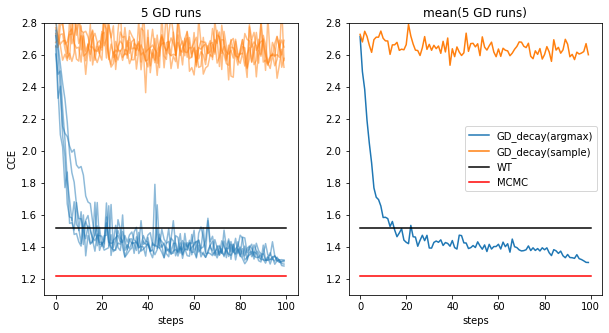

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("5 GD_decay runs")
for k in range(5): plt.plot(top7_GD_decay_sample[k]["losses"], label="GD_decay(sample)",c="tab:orange",alpha=0.5)
for k in range(5): plt.plot(top7_GD_decay[k]["losses"], label="GD_decay(argmax)",c="tab:blue",alpha=0.5)

plt.plot([0,100],[wt_line,wt_line],c="black")
plt.plot([0,100],[mcmc_line,mcmc_line],c="red")
plt.ylim(1.1,2.8)
plt.xlabel("steps")
plt.ylabel("CCE")

plt.subplot(1,2,2)
plt.title("mean(5 GD_decay runs)")
plt.plot(np.mean([top7_GD_decay[k]["losses"] for k in range(5)],0), label="GD_decay(argmax)")
plt.plot(np.mean([top7_GD_decay_sample[k]["losses"] for k in range(5)],0), label="GD_decay(sample)")
plt.plot([0,100],[wt_line,wt_line],c="black",label="WT")
plt.plot([0,100],[mcmc_line,mcmc_line],c="red",label="MCMC")
plt.ylim(1.1,2.8)
plt.xlabel("steps")
plt.legend()

plt.savefig("top7_cce_compare_decay.png", bbox_inches='tight', dpi=300)
plt.show()

## (Linder et al. 2020)

###kl

In [3]:
%%bash
wget -qnc https://github.com/johli/seqprop/raw/master/examples/rosetta/trRosetta/example/T1001_keras_xaa.npz

In [4]:
# correcting the labels!
npz = np.load("T1001_keras_xaa.npz")
_dist = npz["dist"]
_theta = npz["omega"]
_phi = npz["theta"]
_omega = npz["phi"]
_feat = np.concatenate([_theta,_phi,_dist,_omega],-1)

In [5]:
# setting up model
model = mk_design_model(add_pdb=True, pdb_kl=True, n_models=1, diag=0.0)

mode: single sequence design
loading model: xaa
The loss function is composed of the following: ['pdb']


In [6]:
# test if we recapitulate the reported score
# https://github.com/johli/seqprop/blob/master/examples/rosetta/
# seqprop_rosetta_optimization_eval_layernorm_and_basinhopping_T1001_no_msa_1000_updates_multiple_seeds.ipynb
# kl: 1.2452
seq = "NWDELRKKLKKADSPDEWIKELAKRFPGKKVQVISPGKNGNMPCALLAPDGKPDERKEVCPPPDDDDDDDPPDDQNDNHAPPECQKEMKKQNGKKPKRWICIRDDDGMGQCVVIKKPVPPEELKKIMELIARWSMQMQRH"
_seq = np.eye(20)[AA_to_N(seq)[0]][None,None]
out = model.predict(inputs={"I":_seq,"pdb":_feat}, weights={}, train=False)
out["loss"][0,0]

1.2452214

In [7]:
# default optimizer
out_GD_argmax = []
for k in range(5):
  out_GD_argmax.append(model.design(inputs={"pdb":_feat}, weights={}, opt_iter=200))

10 loss:{'pdb':2.6487389}
20 loss:{'pdb':1.5884231}
30 loss:{'pdb':1.5811114}
40 loss:{'pdb':1.0003346}
50 loss:{'pdb':1.014657}
60 loss:{'pdb':0.95726573}
70 loss:{'pdb':0.82689804}
80 loss:{'pdb':0.73644}
90 loss:{'pdb':0.72058755}
100 loss:{'pdb':0.61083364}
110 loss:{'pdb':0.5979255}
120 loss:{'pdb':0.63661325}
130 loss:{'pdb':0.6436629}
140 loss:{'pdb':0.59852064}
150 loss:{'pdb':0.6394377}
160 loss:{'pdb':0.60368997}
170 loss:{'pdb':0.677528}
180 loss:{'pdb':0.66944337}
190 loss:{'pdb':0.6838327}
200 loss:{'pdb':0.71301013}
FINAL loss:{'pdb':0.5805345}
10 loss:{'pdb':2.3916817}
20 loss:{'pdb':1.5160053}
30 loss:{'pdb':1.646744}
40 loss:{'pdb':0.9326429}
50 loss:{'pdb':0.89843214}
60 loss:{'pdb':0.92773956}
70 loss:{'pdb':0.7130878}
80 loss:{'pdb':0.7429637}
90 loss:{'pdb':0.682692}
100 loss:{'pdb':0.7095037}
110 loss:{'pdb':0.7015378}
120 loss:{'pdb':0.62706053}
130 loss:{'pdb':0.6364227}
140 loss:{'pdb':0.62423736}
150 loss:{'pdb':0.62750816}
160 loss:{'pdb':0.64474547}
170 loss

In [8]:
# setting up model
model = mk_design_model(add_pdb=True, pdb_kl=True, n_models=1, diag=0.0, sample=True)

mode: single sequence design
loading model: xaa
The loss function is composed of the following: ['pdb']


In [9]:
out_GD_sample = []
for k in range(5):
  out_GD_sample.append(model.design(inputs={"pdb":_feat}, weights={}, opt_iter=200))

10 loss:{'pdb':3.4976442}
20 loss:{'pdb':2.9843538}
30 loss:{'pdb':3.0861113}
40 loss:{'pdb':2.501779}
50 loss:{'pdb':1.5774313}
60 loss:{'pdb':1.4285662}
70 loss:{'pdb':1.1916168}
80 loss:{'pdb':1.0919087}
90 loss:{'pdb':1.2114313}
100 loss:{'pdb':0.9589799}
110 loss:{'pdb':0.92692405}
120 loss:{'pdb':0.8830884}
130 loss:{'pdb':0.857186}
140 loss:{'pdb':0.88268834}
150 loss:{'pdb':0.81649333}
160 loss:{'pdb':0.8103679}
170 loss:{'pdb':0.81382257}
180 loss:{'pdb':0.7876447}
190 loss:{'pdb':0.77092785}
200 loss:{'pdb':0.8546229}
FINAL loss:{'pdb':0.8372288}
10 loss:{'pdb':3.2582192}
20 loss:{'pdb':3.5121229}
30 loss:{'pdb':2.7347317}
40 loss:{'pdb':2.1346369}
50 loss:{'pdb':1.7350621}
60 loss:{'pdb':1.482808}
70 loss:{'pdb':1.3618081}
80 loss:{'pdb':1.1587148}
90 loss:{'pdb':1.1298898}
100 loss:{'pdb':1.0307965}
110 loss:{'pdb':1.2427431}
120 loss:{'pdb':1.0912141}
130 loss:{'pdb':0.92160684}
140 loss:{'pdb':0.8890913}
150 loss:{'pdb':0.8809929}
160 loss:{'pdb':0.8653693}
170 loss:{'pdb

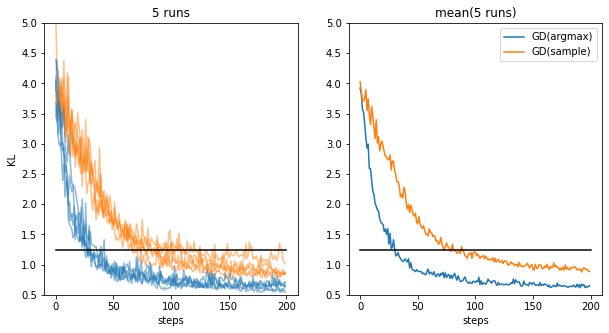

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("5 runs")
for k in range(5): plt.plot(out_GD_sample[k]["losses"], label="GD(sample)",c="tab:orange",alpha=0.5)
for k in range(5): plt.plot(out_GD_argmax[k]["losses"], label="GD(argmax)",c="tab:blue",alpha=0.5)
plt.plot([0,200],[1.2452215,1.2452215],c="black")
plt.ylim(0.5,5.0)
plt.xlabel("steps")
plt.ylabel("KL")

plt.subplot(1,2,2)
plt.title("mean(5 runs)")
plt.plot(np.mean([out_GD_argmax[k]["losses"] for k in range(5)],0), label="GD(argmax)")
plt.plot(np.mean([out_GD_sample[k]["losses"] for k in range(5)],0), label="GD(sample)")
plt.plot([0,200],[1.2452215,1.2452215],c="black")
plt.ylim(0.5,5.0)
plt.xlabel("steps")
plt.legend()
plt.savefig("compare.png", bbox_inches='tight', dpi=300)
plt.show()

### smooth kl

In [12]:
def smooth_kl(true, pred, eps=1e-8):
  # modified from Linder et. al.
  def compute_kl(t,p):
    return (t*np.log(t)).sum(-1) - (t*np.log(p)).sum(-1)

  def compute_skl(t,p,ran):
    t0, t1 = t[...,0],(t[...,1:]*ran).sum(-1)
    p0, p1 = p[...,0],(p[...,1:]*ran).sum(-1)
    t = np.clip([t0,t1,(1-t0-t1)],eps,1-eps)
    p = np.clip([p0,p1,(1-p0-p1)],eps,1-eps)
    return (t*np.log(t)).sum(0) - (t*np.log(p)).sum(0)

  t_feat, p_feat = split_feat(true), split_feat(pred)
  kl,skl = 0,0
  for k in t_feat:
    t,p = t_feat[k],p_feat[k]
    bins = t.shape[-1]-1
    kl += compute_kl(t,p).mean()
    if k in ["dist","phi"]:
      ran = np.linspace(0,1,bins)
      skl += compute_skl(t,p,ran).mean()
    else:
      cir_ran = np.linspace(-np.pi,np.pi,bins)
      for cir in (np.sin,np.cos):
        ran = (cir(cir_ran)+1)/2
        skl += 0.5 * compute_skl(t,p,ran).mean()
  return kl, skl

In [13]:
# setting up model
model = mk_design_model(add_pdb=True, pdb_smooth_kl=True, n_models=1, diag=0.0)

mode: single sequence design
loading model: xaa
The loss function is composed of the following: ['pdb']


In [17]:
out = model.predict(inputs={"I":_seq,"pdb":_feat}, weights={}, train=False)
smooth_kl_baseline = out["loss"][0,0]
smooth_kl_baseline

0.49215925

In [18]:
# default optimizer
out_GD_argmax_smooth = []
for k in range(5):
  out_GD_argmax_smooth.append(model.design(inputs={"pdb":_feat}, weights={}, opt_iter=200))

10 loss:{'pdb':1.3241687}
20 loss:{'pdb':0.76033026}
30 loss:{'pdb':0.508456}
40 loss:{'pdb':0.45225695}
50 loss:{'pdb':0.38275927}
60 loss:{'pdb':0.40529132}
70 loss:{'pdb':0.35068938}
80 loss:{'pdb':0.2895595}
90 loss:{'pdb':0.30522496}
100 loss:{'pdb':0.3027645}
110 loss:{'pdb':0.3212637}
120 loss:{'pdb':0.31752673}
130 loss:{'pdb':0.28340864}
140 loss:{'pdb':0.26720792}
150 loss:{'pdb':0.25756145}
160 loss:{'pdb':0.30705658}
170 loss:{'pdb':0.26933327}
180 loss:{'pdb':0.29941764}
190 loss:{'pdb':0.32994094}
200 loss:{'pdb':0.2544377}
FINAL loss:{'pdb':0.24646908}
10 loss:{'pdb':1.0516294}
20 loss:{'pdb':0.84359276}
30 loss:{'pdb':0.7250841}
40 loss:{'pdb':0.5214863}
50 loss:{'pdb':0.46004504}
60 loss:{'pdb':0.48428547}
70 loss:{'pdb':0.33911696}
80 loss:{'pdb':0.3922433}
90 loss:{'pdb':0.28182662}
100 loss:{'pdb':0.32116187}
110 loss:{'pdb':0.33264607}
120 loss:{'pdb':0.36060762}
130 loss:{'pdb':0.30773887}
140 loss:{'pdb':0.2926623}
150 loss:{'pdb':0.28519198}
160 loss:{'pdb':0.26

In [19]:
# setting up model
model = mk_design_model(add_pdb=True, pdb_smooth_kl=True, n_models=1, diag=0.0, sample=True)

mode: single sequence design
loading model: xaa
The loss function is composed of the following: ['pdb']


In [20]:
out_GD_sample_smooth = []
for k in range(5):
  out_GD_sample_smooth.append(model.design(inputs={"pdb":_feat}, weights={}, opt_iter=200))

10 loss:{'pdb':1.7314734}
20 loss:{'pdb':1.3563648}
30 loss:{'pdb':1.1064432}
40 loss:{'pdb':0.86234254}
50 loss:{'pdb':0.7584716}
60 loss:{'pdb':0.63451236}
70 loss:{'pdb':0.7188943}
80 loss:{'pdb':0.5128813}
90 loss:{'pdb':0.5957945}
100 loss:{'pdb':0.49134213}
110 loss:{'pdb':0.46495825}
120 loss:{'pdb':0.41820636}
130 loss:{'pdb':0.40724847}
140 loss:{'pdb':0.37448886}
150 loss:{'pdb':0.40998486}
160 loss:{'pdb':0.32761618}
170 loss:{'pdb':0.33787477}
180 loss:{'pdb':0.42198727}
190 loss:{'pdb':0.3937504}
200 loss:{'pdb':0.34158027}
FINAL loss:{'pdb':0.3443105}
10 loss:{'pdb':1.6030015}
20 loss:{'pdb':1.2453948}
30 loss:{'pdb':1.0277994}
40 loss:{'pdb':1.0218382}
50 loss:{'pdb':0.81979984}
60 loss:{'pdb':0.73965967}
70 loss:{'pdb':0.6095142}
80 loss:{'pdb':0.5808275}
90 loss:{'pdb':0.62730855}
100 loss:{'pdb':0.49225068}
110 loss:{'pdb':0.5138281}
120 loss:{'pdb':0.4879555}
130 loss:{'pdb':0.47910166}
140 loss:{'pdb':0.53001964}
150 loss:{'pdb':0.45513922}
160 loss:{'pdb':0.4466590

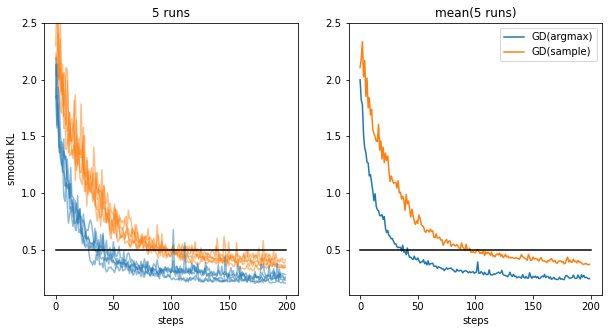

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("5 runs")
for k in range(5): plt.plot(out_GD_sample_smooth[k]["losses"], label="GD(sample)",c="tab:orange",alpha=0.5)
for k in range(5): plt.plot(out_GD_argmax_smooth[k]["losses"], label="GD(argmax)",c="tab:blue",alpha=0.5)
plt.plot([0,200],[smooth_kl_baseline,smooth_kl_baseline],c="black")
plt.ylim(0.1,2.5)
plt.xlabel("steps")
plt.ylabel("smooth KL")

plt.subplot(1,2,2)
plt.title("mean(5 runs)")
plt.plot(np.mean([out_GD_argmax_smooth[k]["losses"] for k in range(5)],0), label="GD(argmax)")
plt.plot(np.mean([out_GD_sample_smooth[k]["losses"] for k in range(5)],0), label="GD(sample)")
plt.plot([0,200],[smooth_kl_baseline,smooth_kl_baseline],c="black")
plt.ylim(0.1,2.5)
plt.xlabel("steps")
plt.legend()
plt.savefig("compare_smooth.png", bbox_inches='tight', dpi=300)
plt.show()

## MSA_DESIGN

In [ ]:
feats = prep_input("6MRR.pdb")
_feat = feats["feat"][None]
_seq = np.eye(20)[AA_to_N(feats["seq"])[0]][None,None]

In [ ]:
model = mk_design_model(add_pdb=True, msa_design=True, feat_drop=0.8, lid=0.3, lid_scale=18.0)

mode: msa design
loading model: xaa
loading model: xab
loading model: xac
loading model: xad
loading model: xae
The loss function is composed of the following: ['pdb']


In [ ]:
# design 10,000 sequences for given backbone
out_msa = []
for k in range(5):
  out_msa.append(model.design(inputs={"pdb":_feat}, weights={}, opt_iter=200, num=10000))

In [ ]:
# switch to PSSM mode
model = mk_design_model(add_pdb=True, pssm_design=True)

mode: pssm design
loading model: xaa
loading model: xab
loading model: xac
loading model: xad
loading model: xae
The loss function is composed of the following: ['pdb']


In [ ]:
out_pssm = []
for _ in range(5):
  out_pssm.append(model.design(inputs={"pdb":_feat}, weights={}, opt_iter=200))

In [ ]:
# switch to single sequence mode
model = mk_design_model(add_pdb=True)

mode: single sequence design
loading model: xaa
loading model: xab
loading model: xac
loading model: xad
loading model: xae
The loss function is composed of the following: ['pdb']


In [ ]:
out_single = []
for _ in range(5):
  out_single.append(model.design(inputs={"pdb":_feat}, weights={}, opt_iter=200))

In [ ]:
wt_loss = model.predict(inputs={"pdb":_feat,"I":_seq},weights={},train=False)["loss"][0,0]
wt_loss

1.6629747

In [ ]:
# score each sequence using TrRosetta single-sequence mode
losses = []
for k in range(5):
  losses.append([])
  for seq in out_msa[k]["I"][:1000]:
    seq = np.eye(20)[seq.argmax(-1)][None,None]
    out = model.predict(inputs={"I":seq,"pdb":_feat}, weights={}, train=False)
    loss = out["loss"][0,0]
    losses[-1].append(loss)

In [ ]:
# pairwise identity
ham = []
for k in range(5):
  msa = out_msa[k]["I"][:1000].argmax(-1)
  ham.append((msa[:,None] == msa[None,:]).mean(-1))
  ham[-1] = ham[-1][np.triu_indices_from(ham[-1],1)]

In [ ]:
def plt_hist(i,bins=30,s=None,e=None,label=None,c=None):
  if s is None: s = np.min(i)
  if e is None: e = np.max(i)
  x,y = np.histogram(i,bins=bins,density=True,range=(s,e))
  y = (y[1:] + y[:-1])/2
  plt.plot(y,x,label=label,c=c)

In [ ]:
%%bash
wget -qnc https://files.ipd.uw.edu/krypton/paper2/6MRR_designs.txt.log.fas
wget -qnc https://files.ipd.uw.edu/krypton/paper2/6MRR.pdb.cf

In [ ]:
def parse_cf(filename, cutoff=0.001):
  # contact Y,1     Y,2     0.006281        MET     ARG
  n,cons = 0, []
  for line in open(filename, "r"):
    line = line.rstrip()
    if line[:7] == "contact":
      _,_,i,_,j,p,_,_ = line.replace(","," ").split()
      i,j,p = int(i),int(j),float(p)
      if i > n: n = i
      if j > n: n = j
      cons.append([i-1,j-1,p])
  cm = np.zeros([n,n])
  for i,j,p in cons: cm[i,j] = p
  return (cm + cm.T)

In [ ]:
names, seqs = parse_fasta("6MRR_designs.txt.log.fas")
msa_ = np.array(AA_to_N(seqs))
cf_ = parse_cf("6MRR.pdb.cf")
msa_s = msa_[:1000]
ham_ = (msa_s[:,None] == msa_s[None,:]).mean(-1)
ham_ = ham_[np.triu_indices_from(ham_,1)]

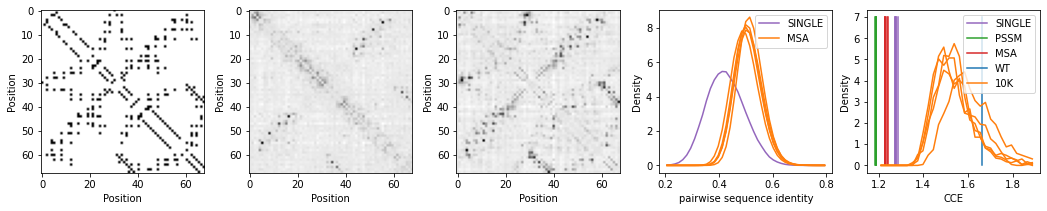

In [ ]:
plt.figure(figsize=(5*3+3,3))

plt.subplot(1,5,1)
plt.imshow(cf_>0.01,cmap="binary")
plt.xlabel("Position"); plt.ylabel("Position")

plt.subplot(1,5,2)
ic = inv_cov(msa_)
plt.imshow(ic,cmap="binary")
plt.xlabel("Position"); plt.ylabel("Position")

plt.subplot(1,5,3)
ic = inv_cov(out_msa[0]["I"].argmax(-1)[:len(msa_)])
plt.imshow(ic,cmap="binary")
plt.xlabel("Position"); plt.ylabel("Position")

plt.subplot(1,5,4)
plt_hist(ham_,bins=41,s=0.2,e=0.8,label="SINGLE",c="tab:purple")
for k in range(5):
  label="MSA" if k == 0 else None
  plt_hist(ham[k],bins=41,c="tab:orange",s=0.2,e=0.8,label=label)
plt.xlabel("pairwise sequence identity")
plt.ylabel("Density")
plt.legend()

plt.subplot(1,5,5)
# single sequence design
for k in range(5):
  label = "SINGLE" if k == 0 else None
  s = out_single[k]["loss"]["pdb"]
  plt.plot([s,s],[0,7],label=label,c="tab:purple")

# pssm design
for k in range(5):
  label = "PSSM" if k == 0 else None
  p = out_pssm[k]["loss"]["pdb"]
  plt.plot([p,p],[0,7],label=label,c="tab:green")

# msa design
for k in range(5):
  m = out_msa[k]["loss"]["pdb"]
  label = "MSA" if k == 0 else None
  plt.plot([m,m],[0,7],label=label,c="tab:red")

# wildtype
w = wt_loss
plt.plot([w,w],[0,7],label="WT")

for k in range(5):
  label = "10K" if k == 0 else None
  plt_hist(losses[k], s=1.2, e=1.9, label=label, c="tab:orange")

plt.legend()
plt.xlabel("CCE")
plt.ylabel("Density")
plt.savefig("fig.png", bbox_inches='tight', dpi=200)

##REDESIGN TEST

In [ ]:
%%bash
wget -qnc https://files.ipd.uw.edu/krypton/paper2/data/redesign_gd.npz.txt
wget -qnc https://files.ipd.uw.edu/krypton/paper2/data/redesign_gd.pdb.txt

In [ ]:
data_npz_gd = np.loadtxt("redesign_gd.npz.txt",np.str)[:,1:].astype(np.float)
data_pdb_gd = np.loadtxt("redesign_gd.pdb.txt",np.str)[:,1:].astype(np.float)

In [ ]:
%%bash
wget -qnc https://files.ipd.uw.edu/krypton/paper2/scos_ivan.txt
wget -qnc https://files.ipd.uw.edu/krypton/paper2/denovo_kl_gd_iter100.txt
wget -qnc https://files.ipd.uw.edu/krypton/paper2/denovo_kl_gd_iter200.txt
wget -qnc https://files.ipd.uw.edu/krypton/paper2/denovo_kl_gd_sample_iter200.txt
wget -qnc https://files.ipd.uw.edu/krypton/paper2/denovo_kl_gd_sample_iter400.txt

In [ ]:
def plt_hist(i,bins=30,s=None,e=None,label=None):
  if s is None: s = np.min(i)
  if e is None: e = np.max(i)
  x,y = np.histogram(i,bins=bins,density=True,range=(s,e))
  y = (y[1:] + y[:-1])/2
  plt.plot(y,x,label=label)

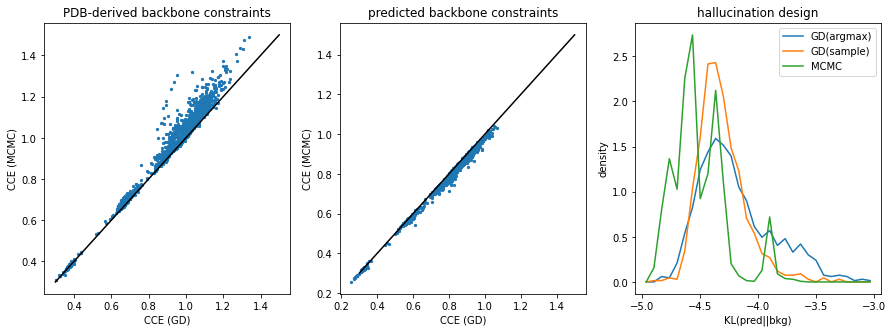

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(data_pdb_gd[:,0],data_pdb_gd[:,2],s=5,cmap="bwr_r")
plt.plot([0.3,1.5],[0.3,1.5],c="black")
plt.title("PDB-derived backbone constraints")
plt.xlabel("CCE (GD)")
plt.ylabel("CCE (MCMC)")

plt.subplot(1,3,2)
plt.scatter(data_npz_gd[:,0],data_npz_gd[:,2],s=5,cmap="bwr_r")
plt.plot([0.3,1.5],[0.3,1.5],c="black")
plt.title("predicted backbone constraints")
plt.xlabel("CCE (GD)")
plt.ylabel("CCE (MCMC)")

plt.subplot(1,3,3)
plt.title("hallucination design")
plt_hist(np.loadtxt("denovo_kl_gd_iter200.txt",np.float),label="GD(argmax)")
plt_hist(np.loadtxt("denovo_kl_gd_sample_iter200.txt",np.float),label="GD(sample)")
plt_hist(np.loadtxt("scos_ivan.txt",np.float)*4,label="MCMC")
plt.ylabel("density")
plt.xlabel("KL(pred||bkg)")
plt.legend()


plt.savefig("mcmc_vs_gd.png", bbox_inches='tight', dpi=300)
plt.show()


##stats

In [26]:
def parse_cf(filename):
  # contact Y,1     Y,2     0.006281        MET     ARG
  n,cons = 0, []
  for line in open(filename, "r"):
    line = line.rstrip()
    if line[:7] == "contact":
      _,_,i,_,j,p,_,_ = line.replace(","," ").split()
      i,j,p = int(i),int(j),float(p)
      if i > n: n = i
      if j > n: n = j
      cons.append([i-1,j-1,p])
  cm = np.zeros([n,n])
  for i,j,p in cons: cm[i,j] = p
  return (cm + cm.T)

def parse_min(filename):
  # 1 T 2 D 3.49406883160592
  n,cons = 0, []
  for line in open(filename, "r"):
    line = line.rstrip()
    i,a,j,b,d = line.replace(","," ").split()
    i,j,d = int(i),int(j),float(d)
    if i > n: n = i
    if j > n: n = j
    cons.append([i-1,j-1,d])
  cm = np.zeros([n,n])
  for i,j,p in cons: cm[i,j] = p
  cm =  (cm + cm.T)
  np.fill_diagonal(cm,np.inf)
  return cm

def parse_depth(filename):
  # chain:residue	all-atom	all-atom(stdev)	MC-atom	MC-atom(stdev)	SC-atom	SC-atom(stdev)	SC-polar-atom	SC-polar-atom(stdev)	SC-nonpolar-atom	SC-nonpolar-atom(stdev)
  #A:1	GLY	  3.40	  0.31	  3.58	  0.25	  3.15	  0.17	  3.15	  0.17	   nan	   nan
  n,cons = 0, []
  for line in open(filename, "r"):
    if line[0] != "#":
      tmp = line.rstrip().split()
      i = int(tmp[0][2:])
      if i > n: n = i
      d = float(tmp[2])
      cons.append([i-1,d])
  depth = np.zeros(n)
  for i,p in cons: depth[i] = p
  return depth

In [27]:
%%bash
wget -qnc https://files.ipd.uw.edu/krypton/paper2/ROS.fas
wget -qnc https://files.ipd.uw.edu/krypton/paper2/short_long_designs.txt
wget -qnc https://files.ipd.uw.edu/krypton/paper2/short_long_designs.pssm.txt
wget -qnc https://files.ipd.uw.edu/krypton/paper2/short_long_designs.msa08.txt
wget -qnc https://files.ipd.uw.edu/krypton/paper2/ss_for_all.txt
wget -qnc https://files.ipd.uw.edu/krypton/paper2/cf_pdb.zip
wget -qnc https://files.ipd.uw.edu/krypton/paper2/min_dist.zip
wget -qnc https://files.ipd.uw.edu/krypton/paper2/mindist_v2.zip
wget -qnc https://files.ipd.uw.edu/krypton/paper2/depth.zip

In [28]:
%%bash
unzip -qqo min_dist.zip
unzip -qqo mindist_v2.zip
unzip -qqo cf_pdb.zip -d native
unzip -qqo depth.zip -d native
ls native/*.cf | sed 's/.pdb.cf//g' | sed 's/native\///g' > cf_list

In [29]:
OK = [k[8:13] for k in parse_fasta("ROS.fas")[0]]

In [30]:
CF,SQ,MN,DP = {},{},{},{}
for id in np.loadtxt("cf_list",np.str):
  CF[id] = parse_cf(f"native/{id}.pdb.cf")
  MN[id] = parse_min(f"NAT/{id}.pdb.min.txt")
  SQ[id] = parse_PDB(f"NAT/{id}.pdb")[-1]
  DP[id] = parse_depth(f"native/{id}.pdb-residue.depth")  
SS = {}
for id,ss,seq in np.loadtxt("ss_for_all.txt",np.str):
  SS[id] = np.array(list(ss))

In [31]:
def get_stats(SQ,MN):
  wt_a = np.zeros(20)
  wt_aa = np.zeros((20,20))
  cpr_a = [[] for _ in range(20)]
  ss_C = np.zeros(20)
  ss_H = np.zeros(20)
  ss_E = np.zeros(20)

  for id in SQ:
    if id in OK:
      if CF[id].shape[0] == SQ[id].shape[0]:
        mn = (MN[id] < 5.0)
        seq = SQ[id]
        seq_oh = np.eye(20)[seq]

        mn_ = np.zeros_like(mn)
        sep_idx = np.triu_indices_from(mn,3)
        mn_[sep_idx] = mn[sep_idx]
        mn = mn_ 

        #pw
        wt_a += seq_oh.sum(0)
        wt_aa += np.einsum("ia,jb,ij->ab", seq_oh, seq_oh, mn)

        #depth
        for c,a in zip(DP[id],seq):
          cpr_a[a].append(c)

        #ss
        ss_C += np.sum(seq_oh[SS[id] == 'L'],0)
        ss_H += np.sum(seq_oh[SS[id] == 'H'],0)
        ss_E += np.sum(seq_oh[SS[id] == 'S'],0)

  wt_a /= wt_a.sum()
  wt_aa += wt_aa.T
  wt_aa /= wt_aa.sum()
  ss = np.array([ss_C/ss_C.sum(),ss_H/ss_H.sum(),ss_E/ss_E.sum()])
  return {"a":wt_a,
          "pw":np.log(wt_aa/(wt_a[:,None]*wt_a[None,:])),
          "ss":np.log(ss/wt_a),
          "cpr":[np.mean(c) for c in cpr_a],
          "cpr_raw":cpr_a}

In [32]:
wt = get_stats(SQ,MN)

In [33]:
SQ_design,MN_design = {},{}
for id,sq in zip(*parse_fasta("ROS.fas")):
  id = id.split()[0][8:13]
  SQ_design[id] = np.array(AA_to_N(sq)[0])
  MN_design[id] = parse_min(f"ROS/{id}.pdb.min.txt")

design_ros = get_stats(SQ_design,MN_design)

In [34]:
SQ_design,MN_design = {},{}
for id,sq in np.loadtxt("short_long_designs.txt",np.str):
  SQ_design[id] = np.array(AA_to_N(sq)[0])
  MN_design[id] = parse_min(f"SEQ/{id}_0001.pdb.min.txt")

design_seq = get_stats(SQ_design,MN_design)

In [35]:
SQ_design,MN_design = {},{}
for id,sq in np.loadtxt("short_long_designs.pssm.txt",np.str):
  SQ_design[id] = np.array(AA_to_N(sq)[0])
  MN_design[id] = parse_min(f"PSSM/{id}_0001.pdb.min.txt")

design_pssm = get_stats(SQ_design,MN_design)

In [36]:
SQ_design,MN_design = {},{}
for id,sq in np.loadtxt("short_long_designs.msa08.txt",np.str):
  SQ_design[id] = np.array(AA_to_N(sq)[0])
  MN_design[id] = parse_min(f"MSA/{id}_0001.pdb.min.txt")

design_msa = get_stats(SQ_design,MN_design)

In [37]:
idx = [13, 9, 10, 19, 12, 17, 18, 4, 0, 3, 6, 11, 1, 8, 2, 5, 15, 16, 7, 14]
np.array(alpha_1)[idx]

array(['F', 'I', 'L', 'V', 'M', 'W', 'Y', 'C', 'A', 'D', 'E', 'K', 'R',
       'H', 'N', 'Q', 'S', 'T', 'G', 'P'], dtype='<U1')

In [38]:
def H_sum(X,aa="A"):
  raw = []
  for a in list(aa):
    k = (np.array(alpha_1) == a).argmax(-1)
    raw += X["cpr_raw"][k]
  bkg = []
  for k in X["cpr_raw"]:
    bkg += k
  return raw, bkg

In [39]:
def plt_hist(i,j,bins=20,s=3.4,e=10,label=None,c=None,rev=False,count=False):
  xi,yi = np.histogram(i, bins=bins, range=(s,e))
  yi = (yi[1:] + yi[:-1])/2
  if rev:
    xj,yj = np.histogram(j, bins=bins, range=(s,e))
    plt.plot(yi,xi/xj,label=label,c=c)  
  elif count:
    plt.plot(yi,xi,label=label,c=c)  
  else:
    plt.plot(yi,xi/xi.sum(),label=label,c=c)  


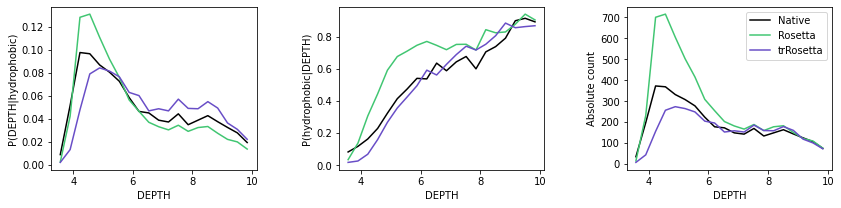

In [40]:
plt.figure(figsize=(14,3))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1,3,1)
plt_hist(*H_sum(wt,"FILVMWY"),label="Native",c="black")
plt_hist(*H_sum(design_ros,"FILVMWY"),label="Rosetta",c='#41C672')
plt_hist(*H_sum(design_seq,"FILVMWY"),label='trRosetta',c='#694EC7')
plt.xlabel("DEPTH"); plt.ylabel("P(DEPTH|hydrophobic)")

plt.subplot(1,3,2)
plt_hist(*H_sum(wt,"FILVMWY"),label="Native",c="black",rev=True)
plt_hist(*H_sum(design_ros,"FILVMWY"),label="Rosetta",c='#41C672',rev=True)
plt_hist(*H_sum(design_seq,"FILVMWY"),label='trRosetta',c='#694EC7',rev=True)
plt.xlabel("DEPTH"); plt.ylabel("P(hydrophobic|DEPTH)")

plt.subplot(1,3,3)
plt_hist(*H_sum(wt,"FILVMWY"),label="Native",c="black",count=True)
plt_hist(*H_sum(design_ros,"FILVMWY"),label="Rosetta",c='#41C672',count=True)
plt_hist(*H_sum(design_seq,"FILVMWY"),label='trRosetta',c='#694EC7',count=True)
plt.xlabel("DEPTH"); plt.ylabel("Absolute count")
plt.legend()

plt.savefig("depth_dist_FILVMWY_3way.png", bbox_inches='tight', dpi=300)
plt.show()

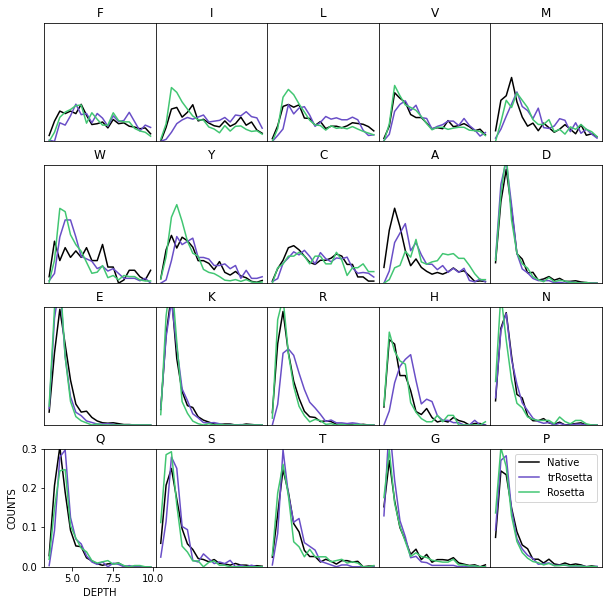

In [ ]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0)
for n in range(20):
  k = idx[n]
  plt.subplot(4,5,n+1)
  plt.title(f"{alpha_1[k]}")
  plt_hist(*H_sum(wt,alpha_1[k]),label="Native",c="black")
  plt_hist(*H_sum(design_seq,alpha_1[k]),label='trRosetta',c='#694EC7')
  plt_hist(*H_sum(design_ros,alpha_1[k]),label="Rosetta",c='#41C672')
  plt.ylim(0,0.3)
  if n != 15:
    plt.xticks([])
    plt.yticks([])
  else:
    plt.xlabel("DEPTH")
    plt.ylabel("COUNTS")
  if n == 19:
    plt.legend()
plt.savefig("depth_dist_ALL.png", bbox_inches='tight', dpi=300)
plt.show()

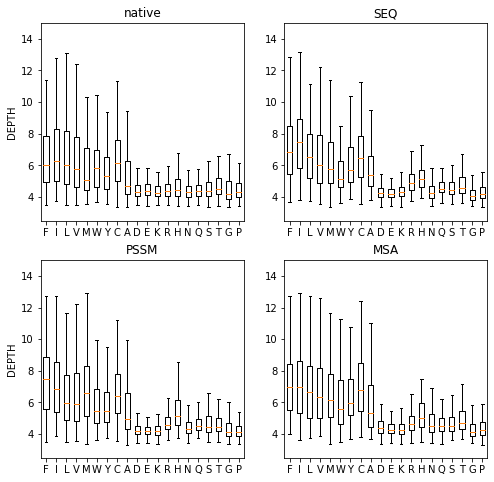

In [41]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1); plt.title("native")
plt.boxplot([wt["cpr_raw"][i] for i in idx],showfliers=False)
plt.xticks(np.arange(1,21), np.array(alpha_1)[idx])
plt.ylabel("DEPTH")
plt.ylim(2.5,15.0)

plt.subplot(2,2,2); plt.title("SEQ")
plt.boxplot([design_seq["cpr_raw"][i] for i in idx],showfliers=False)
plt.xticks(np.arange(1,21), np.array(alpha_1)[idx])
plt.ylim(2.5,15.0)

plt.subplot(2,2,3); plt.title("PSSM")
plt.boxplot([design_pssm["cpr_raw"][i] for i in idx],showfliers=False)
plt.xticks(np.arange(1,21), np.array(alpha_1)[idx])
plt.ylim(2.5,15.0)
plt.ylabel("DEPTH")

plt.subplot(2,2,4); plt.title("MSA")
plt.boxplot([design_msa["cpr_raw"][i] for i in idx],showfliers=False)
plt.xticks(np.arange(1,21), np.array(alpha_1)[idx])
plt.ylim(2.5,15.0)


plt.savefig("cpr_boxplot.png", bbox_inches='tight', dpi=300)
plt.show()

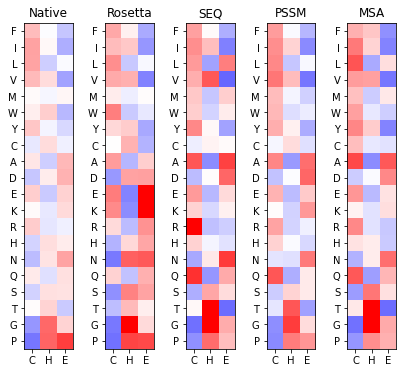

In [48]:
k = idx
vnx = {"cmap":"bwr_r","vmin":-1.5,"vmax":1.5}
plt.figure(figsize=(7,6))
plt.subplot(1,5,1); plt.title("Native")
plt.imshow(wt["ss"][:,idx].T,**vnx)
plt.xticks(np.arange(3), ["C","H","E"]);plt.yticks(np.arange(20), np.array(alpha_1)[k])

plt.subplot(1,5,2); plt.title("Rosetta")
plt.imshow(design_ros["ss"][:,idx].T,**vnx)
plt.xticks(np.arange(3), ["C","H","E"]);plt.yticks(np.arange(20), np.array(alpha_1)[k])

plt.subplot(1,5,3); plt.title("SEQ")
plt.imshow(design_seq["ss"][:,idx].T,**vnx)
plt.xticks(np.arange(3), ["C","H","E"]);plt.yticks(np.arange(20), np.array(alpha_1)[k])

plt.subplot(1,5,4); plt.title("PSSM")
plt.imshow(design_pssm["ss"][:,idx].T,**vnx)
plt.xticks(np.arange(3), ["C","H","E"]);plt.yticks(np.arange(20), np.array(alpha_1)[k])

plt.subplot(1,5,5); plt.title("MSA")
plt.imshow(design_msa["ss"][:,idx].T,**vnx)
plt.xticks(np.arange(3), ["C","H","E"]);plt.yticks(np.arange(20), np.array(alpha_1)[k])

plt.savefig("SS.png", bbox_inches='tight', dpi=300)
plt.show()


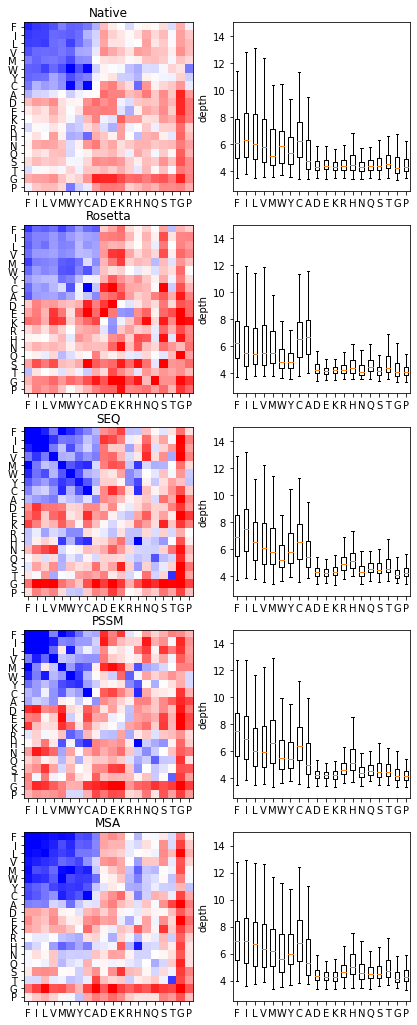

In [76]:
k = idx
plt.figure(figsize=(7,18))

plt.subplot(5,2,1); plt.title("Native")
plt.imshow(wt["pw"][k,:][:,k],**vnx)
plt.xticks(np.arange(20), np.array(alpha_1)[k])
plt.yticks(np.arange(20), np.array(alpha_1)[k])
plt.subplot(5,2,2)
plt.boxplot([wt["cpr_raw"][i] for i in idx],showfliers=False)
plt.xticks(np.arange(1,21), np.array(alpha_1)[idx])
plt.ylabel("depth")
plt.ylim(2.5,15.0)

plt.subplot(5,2,3); plt.title("Rosetta")
plt.imshow(design_ros["pw"][k,:][:,k],**vnx)
plt.xticks(np.arange(20), np.array(alpha_1)[k])
plt.yticks(np.arange(20), np.array(alpha_1)[k])
plt.subplot(5,2,4)
plt.boxplot([design_ros["cpr_raw"][i] for i in idx],showfliers=False)
plt.xticks(np.arange(1,21), np.array(alpha_1)[idx])
plt.ylabel("depth")
plt.ylim(2.5,15.0)

plt.subplot(5,2,5); plt.title("SEQ")
plt.imshow(design_seq["pw"][k,:][:,k],**vnx)
plt.xticks(np.arange(20), np.array(alpha_1)[k])
plt.yticks(np.arange(20), np.array(alpha_1)[k])
plt.subplot(5,2,6)
plt.boxplot([design_seq["cpr_raw"][i] for i in idx],showfliers=False)
plt.xticks(np.arange(1,21), np.array(alpha_1)[idx])
plt.ylabel("depth")
plt.ylim(2.5,15.0)

plt.subplot(5,2,7); plt.title("PSSM")
plt.imshow(design_pssm["pw"][k,:][:,k],**vnx)
plt.xticks(np.arange(20), np.array(alpha_1)[k])
plt.yticks(np.arange(20), np.array(alpha_1)[k])
plt.subplot(5,2,8)
plt.boxplot([design_pssm["cpr_raw"][i] for i in idx],showfliers=False)
plt.xticks(np.arange(1,21), np.array(alpha_1)[idx])
plt.ylabel("depth")
plt.ylim(2.5,15.0)

plt.subplot(5,2,9); plt.title("MSA")
plt.imshow(design_msa["pw"][k,:][:,k],**vnx)
plt.xticks(np.arange(20), np.array(alpha_1)[k])
plt.yticks(np.arange(20), np.array(alpha_1)[k])
plt.subplot(5,2,10)
plt.boxplot([design_msa["cpr_raw"][i] for i in idx],showfliers=False)
plt.xticks(np.arange(1,21), np.array(alpha_1)[idx])
plt.ylabel("depth")
plt.ylim(2.5,15.0)



plt.savefig("PW.png", bbox_inches='tight', dpi=300)
plt.show()


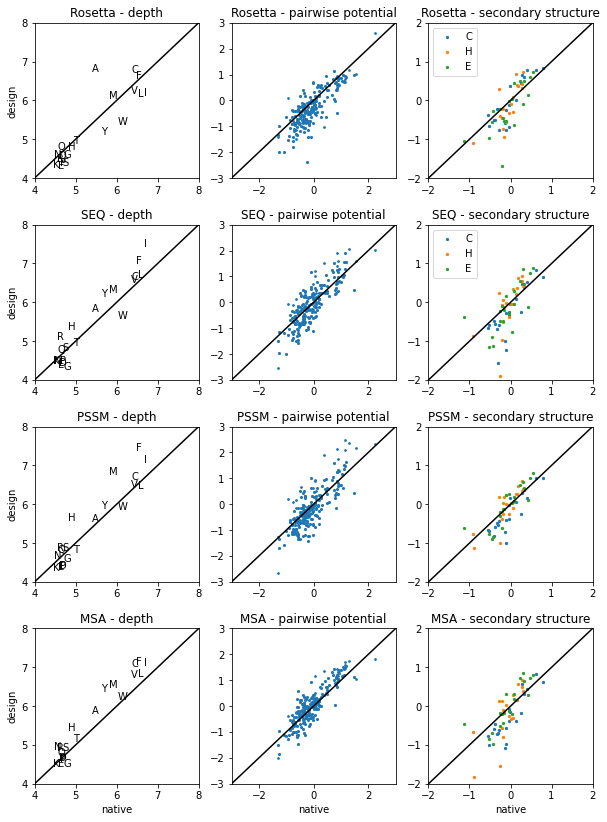

In [55]:
plt.figure(figsize=(10,14))
plt.subplots_adjust(hspace=0.3)

plt.subplot(4,3,1); plt.title("Rosetta - depth")
for k in range(20): plt.text(x=wt["cpr"][k],y=design_ros["cpr"][k],s=alpha_1[k])
plt.xlim(4,8); plt.ylim(4,8);plt.plot([4,8],[4,8],c="black")
plt.ylabel("design")

plt.subplot(4,3,2); plt.title("Rosetta - pairwise potential")
plt.scatter(wt["pw"],design_ros["pw"],s=3)
plt.xlim(-3,3); plt.ylim(-3,3);plt.plot([-3,3],[-3,3],c="black")

plt.subplot(4,3,3); plt.title("Rosetta - secondary structure")
plt.scatter(wt["ss"][0],design_ros["ss"][0],label="C",s=5)
plt.scatter(wt["ss"][1],design_ros["ss"][1],label="H",s=5)
plt.scatter(wt["ss"][2],design_ros["ss"][2],label="E",s=5)
plt.plot([-2,2],[-2,2],c="black")
plt.xlim([-2,2]);plt.ylim([-2,2])
plt.legend()


plt.subplot(4,3,4); plt.title("SEQ - depth")
for k in range(20): plt.text(x=wt["cpr"][k],y=design_seq["cpr"][k],s=alpha_1[k])
plt.xlim(4,8); plt.ylim(4,8);plt.plot([4,8],[4,8],c="black")
plt.ylabel("design")

plt.subplot(4,3,5); plt.title("SEQ - pairwise potential")
plt.scatter(wt["pw"],design_seq["pw"],s=3)
plt.xlim(-3,3); plt.ylim(-3,3);plt.plot([-3,3],[-3,3],c="black")

plt.subplot(4,3,6); plt.title("SEQ - secondary structure")
plt.scatter(wt["ss"][0],design_seq["ss"][0],label="C",s=5)
plt.scatter(wt["ss"][1],design_seq["ss"][1],label="H",s=5)
plt.scatter(wt["ss"][2],design_seq["ss"][2],label="E",s=5)
plt.plot([-2,2],[-2,2],c="black")
plt.xlim([-2,2]);plt.ylim([-2,2])
plt.legend()

plt.subplot(4,3,7); plt.title("PSSM - depth")
for k in range(20): plt.text(x=wt["cpr"][k],y=design_pssm["cpr"][k],s=alpha_1[k])
plt.xlim(4,8); plt.ylim(4,8);plt.plot([4,8],[4,8],c="black")
plt.ylabel("design")

plt.subplot(4,3,8); plt.title("PSSM - pairwise potential")
plt.scatter(wt["pw"],design_pssm["pw"],s=3)
plt.xlim(-3,3); plt.ylim(-3,3);plt.plot([-3,3],[-3,3],c="black")

plt.subplot(4,3,9); plt.title("PSSM - secondary structure")
plt.scatter(wt["ss"][0],design_pssm["ss"][0],label="C",s=5)
plt.scatter(wt["ss"][1],design_pssm["ss"][1],label="H",s=5)
plt.scatter(wt["ss"][2],design_pssm["ss"][2],label="E",s=5)
plt.plot([-2,2],[-2,2],c="black")
plt.xlim([-2,2]);plt.ylim([-2,2])

plt.subplot(4,3,10); plt.title("MSA - depth")
for k in range(20): plt.text(x=wt["cpr"][k],y=design_msa["cpr"][k],s=alpha_1[k])
plt.xlim(4,8); plt.ylim(4,8);plt.plot([4,8],[4,8],c="black")
plt.xlabel("native"); plt.ylabel("design")

plt.subplot(4,3,11); plt.title("MSA - pairwise potential")
plt.scatter(wt["pw"],design_msa["pw"],s=3)
plt.xlim(-3,3); plt.ylim(-3,3);plt.plot([-3,3],[-3,3],c="black")
plt.xlabel("native"); 

plt.subplot(4,3,12); plt.title("MSA - secondary structure")
plt.scatter(wt["ss"][0],design_msa["ss"][0],label="C",s=5)
plt.scatter(wt["ss"][1],design_msa["ss"][1],label="H",s=5)
plt.scatter(wt["ss"][2],design_msa["ss"][2],label="E",s=5)
plt.plot([-2,2],[-2,2],c="black")
plt.xlim([-2,2]);plt.ylim([-2,2])
plt.xlabel("native"); 

plt.savefig("9plot.png", bbox_inches='tight', dpi=300)
plt.show()
